In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import os

In [2]:
# Our data in in the shape: trainings samples(28k) * number of time steps (100 + 6) * time dimension(1)
# The time steps is voltage over time
data = torch.load(f'./data/dataset.ds')

print(data.keys())
print(data['X_train'].shape)
print(data['Y_train'].shape)

dict_keys(['X_train', 'Y_train', 'X_valid', 'Y_valid', 'X_test', 'Y_test'])
torch.Size([28797, 106, 1])
torch.Size([28797, 100])


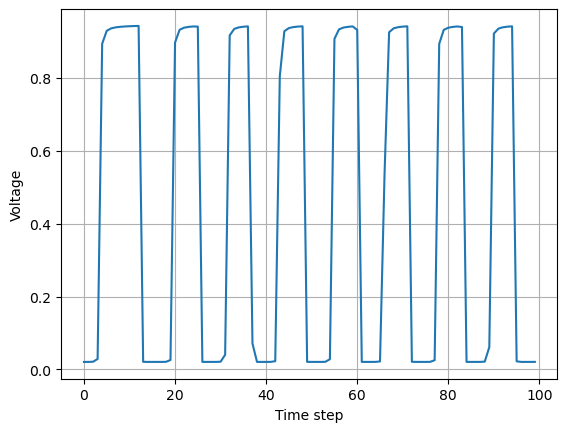

In [3]:
X_train = data['X_train'][1].squeeze().numpy()[:-6] # last 6 are parameters of the simulation i.e. not voltage

plt.plot(X_train)
plt.xlabel("Time step")
plt.ylabel("Voltage")
plt.grid(True)
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self, num_voltage_steps=100, num_params=6, num_inputs=1, num_hidden=128, num_outputs=100, beta=0.9):
        super().__init__()

        self.num_voltage_steps = num_voltage_steps
        self.num_params = num_params

        # Spiking layers (process voltage over time)
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(num_hidden, num_hidden)
        self.lif3 = snn.Leaky(beta=beta)

        # Combine with static parameters before output
        self.fc_out = nn.Linear(num_hidden + num_params, num_outputs)

    def forward(self, x):
        # x: (batch, 106, 1)
        volt = x[:, :self.num_voltage_steps, :]    # shape: (batch, 100, 1)
        params = x[:, self.num_voltage_steps:, 0]  # shape: (batch, 6)

        # Initialize hidden states
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif2.init_leaky()

        # Record spikes/membranes if needed
        spk_rec = []
        mem_rec = []

        for step in range(self.num_voltage_steps):
            cur1 = self.fc1(volt[:, step, :])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif2(cur3, mem3)

            spk_rec.append(spk3)
            mem_rec.append(mem3)

        # Stack over time
        spk_rec = torch.stack(spk_rec, dim=0)
        mem_rec = torch.stack(mem_rec, dim=0)

        # Aggregate over time (e.g. mean firing rate or final membrane)
        mem_final = mem_rec[-1]  # (batch, num_hidden)
        # Alternative: mem_final = mem2_rec.mean(dim=0)

        # Concatenate with static parameters
        combined = torch.cat((mem_final, params), dim=1)  # (batch, num_hidden + 6)

        # Final output (non-spiking)
        out = self.fc_out(combined)

        return out, spk_rec, mem_rec


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
net = Net()
net = torch.compile(net)

cpu


In [6]:
# Test: Example input
x = torch.randn(16, 106, 1).to(device)
out, spk_rec, mem_rec = net(x)
print(out.shape)  # (32, 10)

torch.Size([16, 100])


In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Load your dataset
data = torch.load('./data/dataset.ds')

# Extract tensors
X_train, Y_train = data['X_train'], data['Y_train']
X_valid, Y_valid = data['X_valid'], data['Y_valid']
X_test, Y_test = data['X_test'], data['Y_test']

train_dataset = TensorDataset(X_train, Y_train)
valid_dataset = TensorDataset(X_valid, Y_valid)
test_dataset  = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=2048, num_workers=8, persistent_workers=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2048, num_workers=4, persistent_workers=True, shuffle=False)
# test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())

In [9]:
print("OMP threads:", torch.get_num_threads())
print("Inter-op threads:", torch.get_num_interop_threads())

OMP threads: 20
Inter-op threads: 20


In [10]:
from tqdm import tqdm
import time

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    # -----------------------------
    # TRAINING
    # -----------------------------
    net.train()
    running_loss = 0.0

    # Iterate using tqdm to get a nice progress bar
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()

        optimizer.zero_grad()
        outputs, _, _ = net(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # -----------------------------
    # VALIDATION
    # -----------------------------
    net.eval()
    val_running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs, _, _ = net(X_batch)

            loss = criterion(outputs, y_batch)
            val_running_loss += loss.item() * X_batch.size(0)


    val_loss = val_running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)

    # Only print **once per epoch**
    epoch_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} "
          f"| Time: {epoch_time:.2f}s")

Epoch [1/10] Train Loss: 0.2274 | Val Loss: 0.1625 | Time: 7.78s


Epoch [2/10] Train Loss: 0.1489 | Val Loss: 0.1398 | Time: 6.85s


Epoch [3/10] Train Loss: 0.1374 | Val Loss: 0.1357 | Time: 6.42s


Epoch [4/10] Train Loss: 0.1336 | Val Loss: 0.1328 | Time: 6.63s


Epoch [5/10] Train Loss: 0.1322 | Val Loss: 0.1318 | Time: 6.29s


Epoch [6/10] Train Loss: 0.1304 | Val Loss: 0.1300 | Time: 6.23s


Epoch [7/10] Train Loss: 0.1294 | Val Loss: 0.1288 | Time: 6.38s


Epoch [8/10] Train Loss: 0.1276 | Val Loss: 0.1280 | Time: 6.40s


Epoch [9/10] Train Loss: 0.1266 | Val Loss: 0.1266 | Time: 6.44s


Epoch [10/10] Train Loss: 0.1253 | Val Loss: 0.1233 | Time: 6.27s


In [11]:
torch.save(net, f'./NNs/first_test.pt')

AttributeError: Can't get local object 'atan.<locals>.inner'

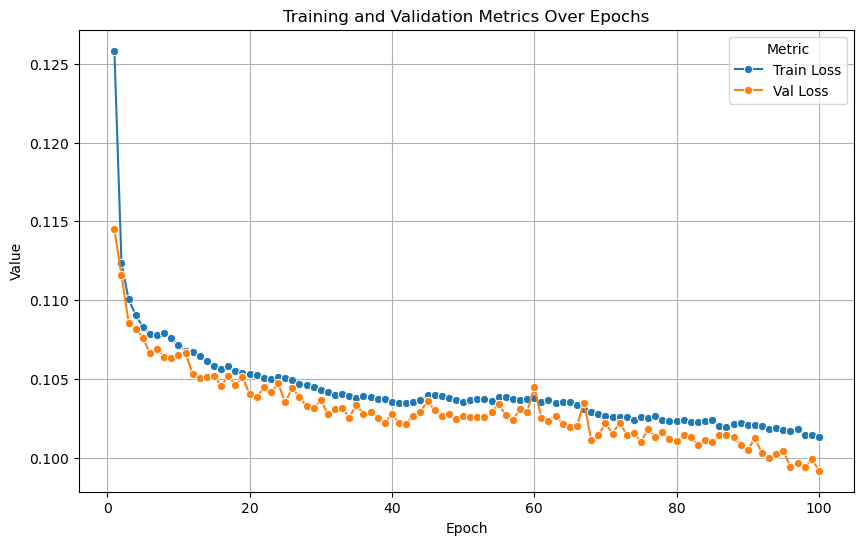

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure your lists have the same length as num_epochs
epochs = list(range(1, num_epochs + 1))

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    "Epoch": epochs * 2,
    "Value": train_losses + val_losses,
    "Metric": ["Train Loss"]*num_epochs + ["Val Loss"]*num_epochs
})

# Plot
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="Epoch", y="Value", hue="Metric", marker="o")
plt.title("Training and Validation Metrics Over Epochs")
plt.grid(True)
plt.show()
